## Lesson 7 Homework
### TLombardi

This notebook uses three ensemble methods, AdaBoost, GDM and XGBoost, to compare predictions of NYC taxi trip durations using big data.

#### 1. Imports

In [1]:
# Imports
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
from sklearn import model_selection
import xgboost as xgb

#### 2. Implement the haversine function to calculate the distance between two lon/lat coordinates and vectorize it using numpy

In [2]:
# Adapted formula from comments in https://gist.github.com/rochacbruno/2883505
def distance_vectorize(s_lat, s_lng, e_lat, e_lng, df):
    
    # approximate radius of earth in km
    R = 6371.0
    
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    df['haversine_distance_km'] = 2 * R * np.arcsin(np.sqrt(d))

#### 3. Read the train.csv from [Kaggle.com](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

In [3]:
# Read file paths
train_filepath = "C:/Users/TVL/Desktop/JHU/SP20_GeoAI/Lesson02/new-york-city-taxi-fare-prediction/train.csv"
test_filepath = "C:/Users/TVL/Desktop/JHU/SP20_GeoAI/Lesson02/new-york-city-taxi-fare-prediction/test.csv"

In [4]:
# Read the files
train = pd.read_csv(train_filepath, 
                         delimiter=',',
                         index_col=0, 
                         nrows = 500_000, 
                         parse_dates=["pickup_datetime",
                                      "dropoff_datetime"])
test = pd.read_csv(test_filepath,
                  parse_dates=["pickup_datetime"])

In [5]:
# list first few rows (datapoints)
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
# check datatypes
train.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, id2875421 to id0013408
Data columns (total 10 columns):
vendor_id             500000 non-null int64
pickup_datetime       500000 non-null datetime64[ns]
dropoff_datetime      500000 non-null datetime64[ns]
passenger_count       500000 non-null int64
pickup_longitude      500000 non-null float64
pickup_latitude       500000 non-null float64
dropoff_longitude     500000 non-null float64
dropoff_latitude      500000 non-null float64
store_and_fwd_flag    500000 non-null object
trip_duration         500000 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 42.0+ MB


In [8]:
# Locate null data
train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 542.3+ KB


#### 4. Clean-up

In [11]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [12]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492545 entries, id2875421 to id0013408
Data columns (total 10 columns):
vendor_id             492545 non-null int64
pickup_datetime       492545 non-null datetime64[ns]
dropoff_datetime      492545 non-null datetime64[ns]
passenger_count       492545 non-null int64
pickup_longitude      492545 non-null float64
pickup_latitude       492545 non-null float64
dropoff_longitude     492545 non-null float64
dropoff_latitude      492545 non-null float64
store_and_fwd_flag    492545 non-null object
trip_duration         492545 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 41.3+ MB


#### 5. Make sure to read the pickup dates as timestamps

In [14]:
# Add columns with month, day of week, and hour of day values
train = train.set_index('pickup_datetime')
train['DayofWeek'] = train.index.dayofweek
train['Hour'] = train.index.hour
train['Month'] = train.index.month
test = test.set_index('pickup_datetime')
test['DayofWeek'] = test.index.dayofweek
test['Hour'] = test.index.hour
test['Month'] = test.index.month

# Display a random sampling of 5 rows
train.sample(5, random_state=0)

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayofWeek,Hour,Month
pickup_datetime,,,,,,,,,,,,
2016-02-12 08:03:14,1,2016-02-12 09:32:05,3,-73.790138,40.647095,-73.980881,40.762527,N,5331,4,8,2
2016-03-08 13:57:02,1,2016-03-08 14:12:16,2,-74.008438,40.712521,-73.990364,40.746391,N,914,1,13,3
2016-02-20 00:06:31,2,2016-02-20 00:13:19,2,-73.977669,40.787151,-73.984894,40.768280,N,408,5,0,2
2016-01-27 17:56:40,1,2016-01-27 18:02:32,1,-73.994362,40.745697,-74.005791,40.733006,N,352,2,17,1
2016-01-29 20:46:42,1,2016-01-29 21:02:53,1,-73.993736,40.762077,-73.955986,40.778721,N,971,4,20,1


In [15]:
test.sample(5, random_state=0)

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DayofWeek,Hour,Month
pickup_datetime,,,,,,,,,
2014-03-11 20:24:02+00:00,2014-03-11 20:24:02.0000001,-73.963902,40.765338,-73.976445,40.764152,2,1,20,3
2014-12-24 03:00:00+00:00,2014-12-24 03:00:00.00000018,-73.980602,40.730085,-73.978402,40.774817,1,2,3,12
2013-09-25 22:00:00+00:00,2013-09-25 22:00:00.00000053,-73.874600,40.773985,-73.960362,40.757420,1,2,22,9
2013-02-10 19:51:53+00:00,2013-02-10 19:51:53.0000002,-73.998873,40.725026,-73.960968,40.757409,1,6,19,2
2012-11-11 20:35:40+00:00,2012-11-11 20:35:40.0000001,-73.789967,40.646832,-73.973090,40.684484,1,6,20,11


In [16]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [17]:
train.head()

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayofWeek,Hour,Month
0,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,3
1,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,6
2,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,1
3,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,4
4,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,3


In [18]:
test.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DayofWeek,Hour,Month
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,1,13,1
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,1,13,1
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,5,11,10
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,5,21,12
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,5,21,12


#### 6. Plot using seaborn the distribution by:
     - month
     - day of week
     - hour of day

Text(0.5, 0, 'Month')

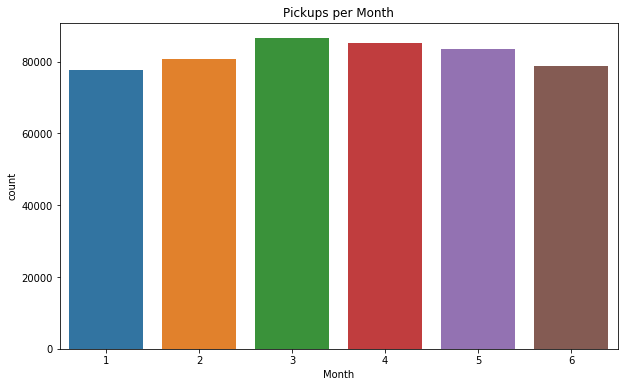

In [19]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Pickups per Month")

# Bar chart showing total counts of pickup days of the week
sns.countplot('Month', data=train)

# Add label for vertical axis
plt.xlabel("Month")

Text(0.5, 0, 'Day of the Week')

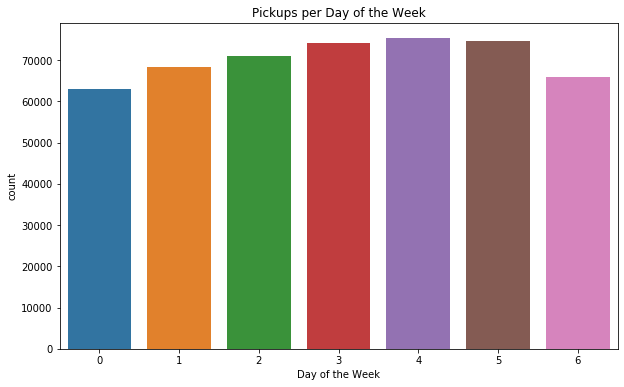

In [20]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Pickups per Day of the Week")

# Bar chart showing total counts of pickup days of the week
sns.countplot('DayofWeek', data=train)

# Add label for vertical axis
plt.xlabel("Day of the Week")

Text(0.5, 0, 'Hour of the Day')

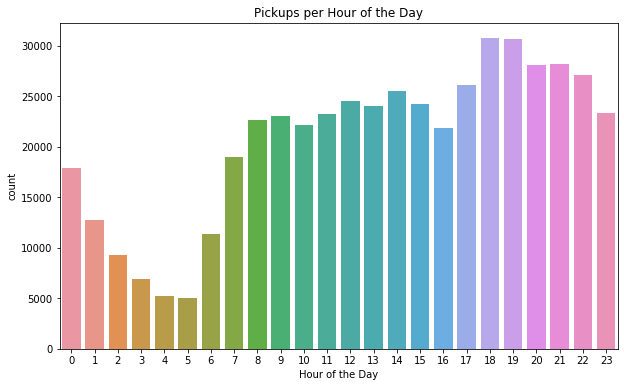

In [21]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Pickups per Hour of the Day")

# Bar chart showing total counts of pickups per hour of the day
sns.countplot('Hour', data=train)

# Add label for vertical axis
plt.xlabel("Hour of the Day")

#### 7. Append the haversine distance to the trip record and show top 10 longest records

In [22]:
# Append the haversine distance to the trip record 
distance_vectorize(train.pickup_latitude, 
                   train.pickup_longitude,
                   train.dropoff_latitude,
                   train.dropoff_longitude, 
                   train)

# Show top 10 longest records
train.nlargest(10,['haversine_distance_km'])

,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayofWeek,Hour,Month,haversine_distance_km
86424,1,2016-04-29 06:58:11,1,-73.789116,40.641712,-73.990295,40.832928,N,2735,4,6,4,27.191629
179013,2,2016-05-14 05:12:26,1,-73.776634,40.645370,-73.940659,40.849697,N,2128,5,4,5,26.591816
306668,2,2016-02-18 18:52:13,5,-73.776833,40.645378,-73.940247,40.848572,N,3183,3,17,2,26.457531
186152,2,2016-01-01 06:52:57,6,-73.781090,40.645077,-73.937271,40.849789,N,1718,4,6,1,26.291671
483942,1,2016-01-27 20:10:58,2,-73.776718,40.645321,-73.931160,40.849964,N,2128,2,19,1,26.212000
1362,2,2016-06-05 05:23:19,1,-73.777443,40.646641,-73.935776,40.848473,N,1515,6,4,6,26.107012
424738,2,2016-01-15 21:56:25,1,-73.780144,40.645706,-73.938980,40.846321,N,2777,4,21,1,26.012738
298817,1,2016-03-08 23:42:02,1,-73.789536,40.643532,-73.939407,40.847809,N,2128,1,23,3,25.987645
101850,2,2016-04-01 00:14:07,1,-73.781929,40.644650,-73.942886,40.843578,N,1808,3,23,3,25.945272
140726,2,2016-01-24 21:46:54,5,-73.788177,40.641491,-73.937958,40.845161,N,1907,6,21,1,25.925179


In [23]:
# Append the haversine distance to the trip record 
distance_vectorize(test.pickup_latitude, 
                   test.pickup_longitude,
                   test.dropoff_latitude,
                   test.dropoff_longitude, 
                   test)

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 10 columns):
key                      9914 non-null object
pickup_longitude         9914 non-null float64
pickup_latitude          9914 non-null float64
dropoff_longitude        9914 non-null float64
dropoff_latitude         9914 non-null float64
passenger_count          9914 non-null int64
DayofWeek                9914 non-null int64
Hour                     9914 non-null int64
Month                    9914 non-null int64
haversine_distance_km    9914 non-null float64
dtypes: float64(5), int64(4), object(1)
memory usage: 774.7+ KB


In [25]:
# Locate null data
train.isnull().sum()

vendor_id                0
dropoff_datetime         0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
trip_duration            0
DayofWeek                0
Hour                     0
Month                    0
haversine_distance_km    0
dtype: int64

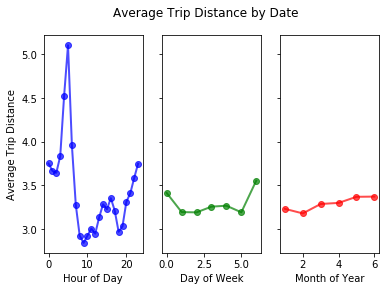

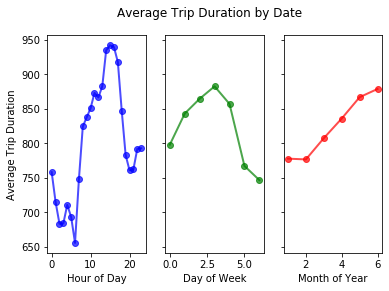

In [26]:
# Visualize average trip distance and average trip duration for time series variables
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['haversine_distance_km'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('DayofWeek').mean()['haversine_distance_km'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['haversine_distance_km'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Trip Distance')
fig.suptitle('Average Trip Distance by Date')
plt.show()
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['trip_duration'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('DayofWeek').mean()['trip_duration'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['trip_duration'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Trip Duration')
fig.suptitle('Average Trip Duration by Date')
plt.show()

In [27]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

#### 8. Create Dummy Variables

In [28]:
for feature in train.columns: # Loop through all columns in the dataframe
    if train[feature].dtype == 'object':
        train[feature] = pd.Categorical(train[feature]).codes

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492545 entries, 0 to 492544
Data columns (total 14 columns):
vendor_id                492545 non-null int64
dropoff_datetime         492545 non-null datetime64[ns]
passenger_count          492545 non-null int64
pickup_longitude         492545 non-null float64
pickup_latitude          492545 non-null float64
dropoff_longitude        492545 non-null float64
dropoff_latitude         492545 non-null float64
store_and_fwd_flag       492545 non-null int8
trip_duration            492545 non-null int64
DayofWeek                492545 non-null int64
Hour                     492545 non-null int64
Month                    492545 non-null int64
haversine_distance_km    492545 non-null float64
log_trip_duration        492545 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(6), int8(1)
memory usage: 49.3 MB


In [30]:
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['DayofWeek'], prefix='dow', prefix_sep='_')

In [31]:
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_test = pd.get_dummies(test['DayofWeek'], prefix='dow', prefix_sep='_')

In [32]:
train = train.drop(['vendor_id','passenger_count','store_and_fwd_flag','Month','Hour','DayofWeek','trip_duration',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_datetime'],axis = 1)

In [33]:
test = test.drop(['key','passenger_count','Month','Hour','DayofWeek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)

In [34]:
Train_Master = pd.concat([train,
                          passenger_count_train,
                          month_train,
                          hour_train,
                          dow_train],
                          axis=1)
Test_Master = pd.concat([test,
                          passenger_count_train,
                          month_train,
                          hour_train,
                          dow_train],
                          axis=1)

In [35]:
Train_Master.shape

(492545, 46)

In [36]:
Train_Master.head()

,haversine_distance_km,log_trip_duration,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,m_1,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,1.498521,6.122493,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.805507,6.498282,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6.385098,7.661527,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1.485498,6.063785,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.188588,6.077642,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
Test_Master.shape

(492545, 45)

In [38]:
Test_Master.head()

,haversine_distance_km,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,m_1,m_2,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2.323260,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2.425353,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.618628,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1.961033,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5.387301,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


##### Define variables

In [39]:
Train, Test = skl.model_selection.train_test_split(Train_Master[0:100000], test_size = 0.2)

In [40]:
X_train = Train.drop(['log_trip_duration'], axis=1)
y_train = Train["log_trip_duration"]
X_valid = Test.drop(['log_trip_duration'], axis=1)
y_valid = Test["log_trip_duration"]

In [41]:
y_valid = y_valid.reset_index().drop('index',axis = 1)
y_train = y_train.reset_index().drop('index',axis = 1)

#### 9. AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import explained_variance_score

ada = AdaBoostRegressor(n_estimators=50, 
                        learning_rate=0.2,
                        loss='exponential').fit(X_train, 
                                                y_train)
pred = ada.predict(X_valid)
adab = ada.score(X_valid,
                 y_valid)
predict = ada.predict(X_valid)
exp_ada = explained_variance_score(predict,
                                   y_valid)

C:\Users\TVL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
adab

0.61727447661198

In [44]:
exp_ada

0.31656495066329815

#### 10. Gradient Boost 

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=400, 
                                max_depth=5, 
                                loss='ls',
                                min_samples_split=2,
                                learning_rate=0.1).fit(X_train, 
                                                       y_train)
gradient = est.score(X_valid,
                     y_valid)
pred = est.predict(X_valid)
exp_est = explained_variance_score(pred,
                                   y_valid)

C:\Users\TVL\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
gradient

0.6757778160850216

In [47]:
exp_est

0.5399758758782292

#### 11. XGBoost

In [48]:
XGB = xgb.XGBRegressor()

In [49]:
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [50]:
y_pred = XGB.predict(X_valid)

In [51]:
XGB.score(X_valid, y_valid)

0.6741388101492065

In [54]:
exp_xgb = explained_variance_score(y_pred,
                                   y_valid)

In [55]:
exp_xgb

0.5384594175199382

In [52]:
from matplotlib import pyplot
from xgboost import plot_tree, plot_importance

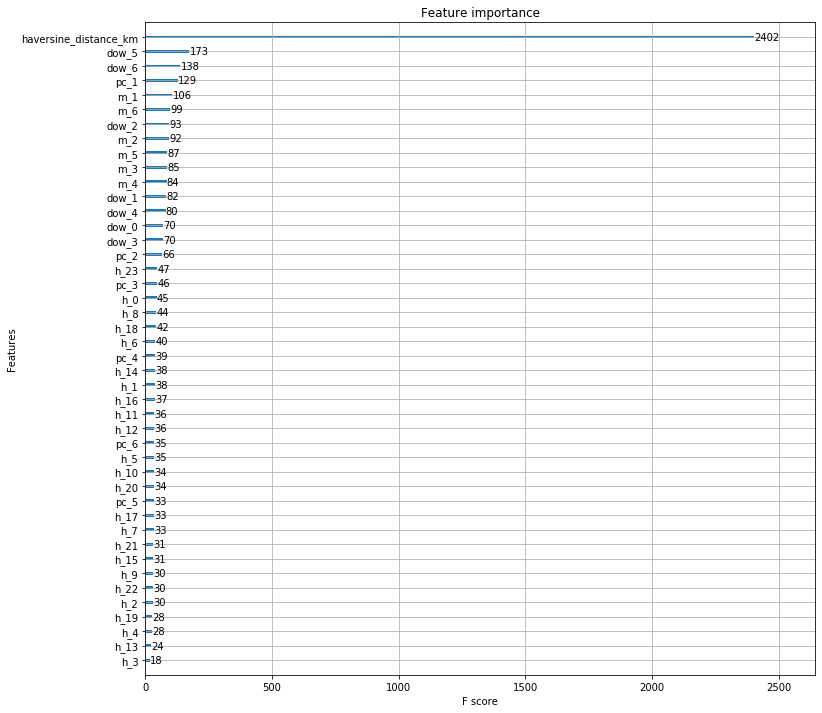

In [53]:
_, ax = pyplot.subplots(figsize=(12,12))
ax = plot_importance(XGB, ax=ax)